# Project 1.1: Object Detection in Urban Environments
## Part 1: Exploring the dataset — Basics
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Fetch the [Waymo Open Dataset](https://waymo.com/open/);
* Visualise a few images and their bounding boxes.

## 1. Introduction

In [190]:
### Importing the required modules

In [191]:
import glob
import logging
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import os

In [192]:
### Installing the Waymo Open Dataset API and dependencies
!pip3 install --quiet --upgrade pip
!pip3 install --quiet numpy==1.21.6
!pip3 install --quiet waymo-open-dataset-tf-2-6-0==1.4.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 37.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0+zzzcolab20220506153740 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
jax 0.3.17 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.


In [193]:
#### Importing the Waymo Open Dataset API
import google.protobuf
import tensorflow as tf
import waymo_open_dataset
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset import label_pb2

In [194]:
### Setting the environment variables

In [195]:
ENV_COLAB = True                # True if running in Google Colab instance

In [196]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [197]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [198]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. The Waymo Open Dataset

The [Waymo Open Dataset for Perception](https://waymo.com/open/data/perception) [1] is a publicly available dataset consisting of high-resolution sensor data and labels for 2,030 driving scenes.

A nice summary of the `waymo_open_dataset` API and data attributes can be found on [this repository](https://github.com/Jossome/Waymo-open-dataset-document) by GitHub user Jossome [2] or in the TensorFlow Datasets Catalog [here](https://www.tensorflow.org/datasets/catalog/waymo_open_dataset).

#### Getting familiar with classes

The `Box` attribute has a label that can be one of five possible object classes defined in [`label.proto`](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/label.proto#L63):
```
TYPE_UNKNOWN = 0
TYPE_VEHICLE = 1
TYPE_PEDESTRIAN = 2
TYPE_SIGN = 3
TYPE_CYCLIST = 4
```

#### Closer look at bounding boxes data

##### `CameraLabels`

The Waymo Open Dataset is a multi-sensor, multi-modal dataset. Every frame in the dataset consists of data captured from multiple camera views surrounding the Waymo ego vehicle. The data from any one camera can be accessed with `frame.camera_labels` access chain, followed by any one of the following `CameraName` enums defined in [`dataset.proto`](ataset/blob/master/waymo_open_dataset/dataset.proto#L48):
```
UNKNOWN = 0
FRONT = 1
FRONT_LEFT = 2
FRONT_RIGHT = 3
SIDE_LEFT = 4
SIDE_RIGHT = 5
```

To access the front camera's bounding box data, for example, the following access chain is used:
```
boxes = frame.camera_labels[0]
```
which will return a `waymo_open_dataset.dataset_pb2.CameraLabels` instance.

Note that we have to access each camera's data by its index. In the Waymo Open Dataset v1.2, the camera indices are slightly different from the above Enum definitions. That is, there is no `UNKNOWN` camera label, and the camera indices starting with `FRONT` begin at index `0`.

##### `Label`

To access the first `Box` instance from the `FRONT` camera, we can use
```
box = frame.camera_labels[0].labels[0]
```
which will return a single `waymo_open_dataset.label_pb2.Label` instance. Each `Label` instance has several important attributes:

* `box`: the upright bounding box coordinates and dimensions in vehicle frame;
* `type`: the class label (int) of the object (e.g., `TYPE_VEHICLE`, `TYPE_PEDESTRIAN`);
* `id`: the unique identifier assigned to this object;
* `detection_difficulty_level`: the difficulty level for detection;
* `tracking_difficulty_level`: the difficulty level for tracking.

##### Converting from int to string labels


Both the bounding box `Label.type` and camera `CameraLabels.name` attributes are encoded as integer values. For example, `Label.type` could return `1` which, when inspecting the `label.proto` file, indicates that this bounding box contains a `TYPE_VEHICLE` object. In order to retrieve the string versions of these enum values, Waymo provides two helpful API calls.

To get the camera label as a string, e.g., `FRONT`, use:
```
from waymo_open_dataset import dataset_pb2 as open_dataset

open_dataset.CameraName.Name.Name([my_camera_label].name)
```
where `[my_camera_label]` is replaced with the `CameraLabels` object instance you wish to convert from integer to string representation. Note that `[my_camera_label]` is a single image from the set of images returned by calling the `frame.images` attribute. Using the `dataset_pb2.CameraName...Name()` access chain will return the string label of the camera used to capture the image in question.

To get the bounding box label as a string, e.g., `TYPE_VEHICLE`, use:
```
from waymo_open_dataset import label_pb2

label_pb2.Label.Type.Name([my_bbox_label].type)
```
where `[my_bbox_label]` is replaced with the `Label` instance you wish to convert from integer to string representation. Note that `[my_bbox_label]` is a single bounding box annotation from the set of bounding boxes returned by calling the `frame.labels` attribute. Using the `label_pb2.Label..Name()` access chain will return the string label of the object class for the bounding box in question.


More on the specifics of the attribute values can be found in the [`label.proto`](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/label.proto) file and on the [`labeling_specifications.md`](https://github.com/waymo-research/waymo-open-dataset/blob/master/docs/labeling_specifications.md) document.

## 2. Programming Task

### 2.1. Fetching the Waymo Open Dataset

In [199]:
### Path to store all downloaded `.tfrecord` training files
DIR_TRAIN = os.path.join(DIR_SRC, 'train')

In [12]:
### Create subdirectory if not already exists
os.makedirs(DIR_TRAIN, exist_ok=True)

#### Using `gsutil`

In [21]:
### Authenticating the Google user account authorized to access 
#   the Waymo Open Dataset via GCS / gsutil
from google.colab import auth
auth.authenticate_user()

In [26]:
!gcloud auth login
!gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=dWNIxLapJVYJ6VlbeBljNsqEM0X8bT&prompt=consent&access_type=offline&code_challenge=P2A-972GqVzjDR7Ry6842871ngytbS6s5Rz8amBjFCE&code_challenge_method=S256

Enter authorization code: 4/0ARtbsJpNJ6WgGOE39PcQjvr7NuaqnhmtI644uSDw8nPw42y5hY4HDXKgKip2t8AtnqCnyg

You are now logged in as [jonathan.moran107@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_

In [27]:
### Setting the gsutil variables
bucket_name = 'waymo_open_dataset_v_1_2_0_individual_files/training/'
file_name = 'segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'

In [28]:
### Downloading the specified `.tfrecord` fle via GCS gsutil
#   Note: GCS Public or Authenticated URLs do *not* work (`Permission denied`)
!gsutil cp "{'gs://' + bucket_name + file_name}" "{DIR_TRAIN}"

Copying gs://waymo_open_dataset_v_1_2_0_individual_files/training/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord...
| [1 files][940.1 MiB/940.1 MiB]   60.0 MiB/s                                   
Operation completed over 1 objects/940.1 MiB.                                    


In [29]:
### List of all `.tfrecord` files in training subdirectory
files_to_convert = [f for f in os.listdir(DIR_TRAIN) if (
                    f.endswith('.tfrecord'))]
files_to_convert

['segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']

In [30]:
### Alternatively, we can use glob to get the absolute paths
file_paths_to_convert = glob.glob('{}//*.tfrecord'.format(DIR_TRAIN))
file_paths_to_convert

['/content/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']

#### Getting the first frame

In [31]:
### Trying with the example record fetched from GCS
FILE_PATH_WAYMO = file_paths_to_convert[0]
example_set = tf.data.TFRecordDataset(FILE_PATH_WAYMO, compression_type='')
# Return the first frame in the record
for i, data in enumerate(example_set):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    frame_nr = i+1
    break

The Waymo `Frame` object is a container for all attributes collected at a specific context (point in time within a driving scene).

In [32]:
type(frame)

waymo_open_dataset.dataset_pb2.Frame

The tree structure listing the attributes associated with a `Frame` object are visualised nicely on the [Waymo Open Dataset Document](https://github.com/Jossome/Waymo-open-dataset-document) repository.

In [33]:
frame.context

name: "1005081002024129653_5313_150_5333_150"
camera_calibrations {
  name: FRONT
  intrinsic: 2083.091212133254
  intrinsic: 2083.091212133254
  intrinsic: 957.2938286685071
  intrinsic: 650.5697927719348
  intrinsic: 0.04067236637270731
  intrinsic: -0.3374271466716414
  intrinsic: 0.0016273829099200004
  intrinsic: -0.0007879327563938157
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999151800844592
    transform: -0.008280529275085654
    transform: -0.010053132426658727
    transform: 1.5444145042510942
    transform: 0.008380895965622895
    transform: 0.9999150476776223
    transform: 0.009982885888937929
    transform: -0.022877347388980857
    transform: 0.009969614810858722
    transform: -0.010066293398396434
    transform: 0.9998996332221252
    transform: 2.115953541712884
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: RIGHT_TO_LEFT
}
camera_calibrations {
  name: FRONT_LEFT
  intr

### 2.2. Visualising the Waymo OD data

#### Visualising a single frame

The following `show_camera_image` function from Waymo allows us to preview all five camera views captured in a single frame.

In [34]:
### From Waymo Research's `tutorial.ipynb`
# Credit: https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb

In [42]:
def show_camera_image(camera_image, camera_labels, layout, cmap=None):
    """Show a camera image and the given camera labels."""

    ax = plt.subplot(*layout)
    # Draw the camera labels.
    for camera_label in camera_labels:
        # Ignore camera labels that do not correspond to this camera.
        if camera_label.name != camera_image.name:
            continue
        # Iterate over the individual labels.
        for label in camera_label.labels:
            # Draw the object bounding box.
            ax.add_patch(patches.Rectangle(
                xy=(label.box.center_x - 0.5 * label.box.length,
                label.box.center_y - 0.5 * label.box.width),
                width=label.box.length,
                height=label.box.width,
                linewidth=1,
                edgecolor='red',
                facecolor='none')
            )
    # Show the camera image.
    plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
    plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
    plt.grid(False)
    plt.axis('off')

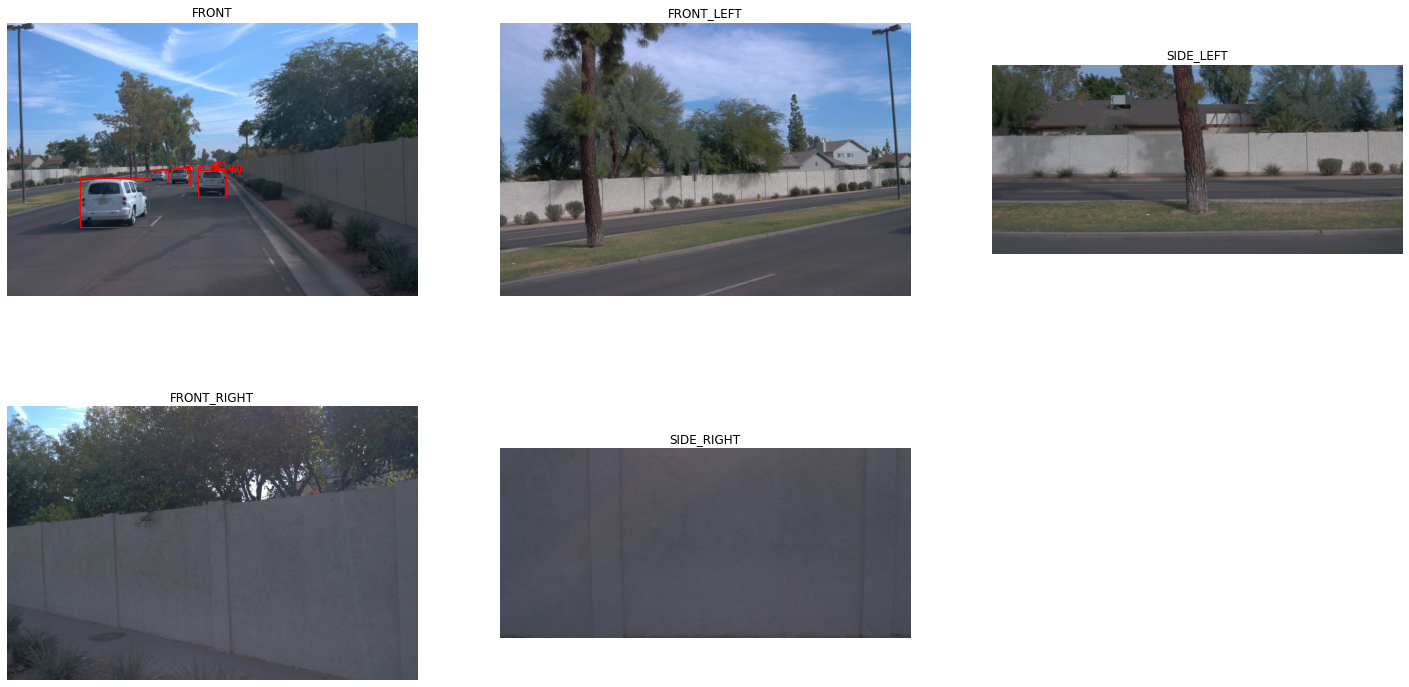

In [89]:
### Rendering the frame from all five camera views
plt.figure(figsize=(25, 20))
for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])
plt.savefig('{}/vis_frame-{}_{}.png'.format(DIR_OUT, frame_nr, frame.context.name))

In [51]:
from waymo_open_dataset import label_pb2

In [58]:
open_dataset.CameraName.Name.Name(frame.camera_labels[0].name)

'FRONT'

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [70]:
### From Udacity's `utils.py`

In [200]:
def parse_frame(frame, camera_name='FRONT'):
    """ take a frame, output bbox + image"""
    # get image
    images = frame.images
    for im in images:
        if open_dataset.CameraName.Name.Name(im.name) != camera_name:
            continue
        encoded_jpeg = im.image
    
    # get bboxes
    labels = frame.camera_labels
    for lab in labels:
        if open_dataset.CameraName.Name.Name(lab.name) != camera_name:
            continue
        annotations = lab.labels
    return encoded_jpeg, annotations

In [72]:
### From Udacity's `Exploratory Data Analysis.ipynb`

In [201]:
def display_instances(
    batch: tf.data.Dataset, class_colourmap, num_frames=10,
    camera_label='FRONT', **params
):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.

    :param batch: the tf.data.BatchDataset instance of Waymo OD frames.
    :param class_colourmap: the class-colour mapping for bbox annotations.
    :param num_frames: number of frames to display in the plot.
    :param camera_label: the label of the camera to return images captured from.
    :param **params: the dict of keyword arguments to pass into Matplotlib call.
    """
    # ADD CODE HERE

    # Create the Matplotlib ImageGrid figure
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)
    grid.axes_all[2].set_title(label=label, fontname=fontname)
    frame_nr = 0
    for i, data in enumerate(batch):
        if frame_nr == num_frames:
            break
        # Read in the frame from the batch
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        frame_nr = i+1
        # Parse the frame and obtain the images and labels
        image, labels = parse_frame(frame, camera_label)
        # Plot the image and its bounding box labels
        grid[i].imshow(tf.io.decode_image(image))
        grid[i].axis('off')
        # Iterate over the individual labels.
        for lbl in labels:
            # Draw the object bounding box.
            grid[i].add_patch(patches.Rectangle(
                xy=(lbl.box.center_x - 0.5 * lbl.box.length,
                lbl.box.center_y - 0.5 * lbl.box.width),
                width=lbl.box.length,
                height=lbl.box.width,
                linewidth=1,
                edgecolor=class_colourmap[
                    label_pb2.Label.Type.Name(lbl.type)
                ],
                facecolor='none')
            )

In [107]:
label_pb2.Label.Type.Name(frame.camera_labels[0].labels[0].type)

'TYPE_VEHICLE'

In [90]:
label_pb2.Label.Type.Name(1)

'TYPE_VEHICLE'

In [94]:
label_pb2.Label.Type.Value('TYPE_VEHICLE')

1

In [91]:
label_pb2.Label.Type.Name(2)

'TYPE_PEDESTRIAN'

In [93]:
label_pb2.Label.Type.Name(4)

'TYPE_CYCLIST'

In [202]:
# Function parameters
num_frames = 10
camera_label = 'FRONT'

# Bounding box colours
class_colourmap = {
    'TYPE_VEHICLE':    'red',
    'TYPE_PEDESTRIAN': 'blue',
    'TYPE_SIGN':       'yellow',
    'TYPE_CYCLIST':    'green'
}

# ImageGrid parameters
figsize = (24,24)
ncols = 5
nrows = num_frames // ncols
axes_pad = 0.2
fontname = 'Times New Roman'
label = "'FRONT' camera images in batch"
grid_params = {'figsize': figsize, 'ncols': ncols, 'nrows': nrows, 'axes_pad': axes_pad}

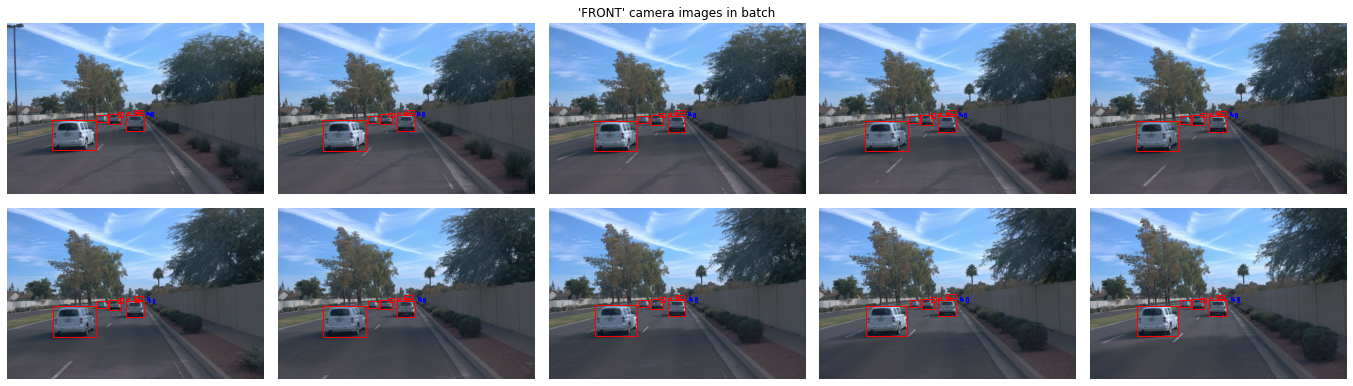

In [112]:
display_instances(
    example_set, class_colourmap, num_frames, camera_label, **grid_params
)

#### Visualising randomly sampled frames 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [119]:
## STUDENT SOLUTION HERE

In [152]:
file_paths_to_convert[0]

'/content/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'

In [157]:
### Fetching the records collected from GCS
FILE_PATH_WAYMO = file_paths_to_convert[0]
### Creating the `TFRecordDataset` instance
example_set = tf.data.TFRecordDataset(FILE_PATH_WAYMO, compression_type='')
### Checking the first frame in the dataset for validity
for i, data in enumerate(example_set):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    frame_nr = i+1
    break

In [158]:
type(frame)

waymo_open_dataset.dataset_pb2.Frame

In [159]:
### Shuffling the dataset on each iteration of `take`
example_set.shuffle(buffer_size=1, reshuffle_each_iteration=True)
### Randomly sampling from the set
sample_batch = example_set.take(count=1)

In [163]:
type(sample_batch)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [164]:
### Fetching the first frame in the randomly-sampled batch
for i, data in enumerate(sample_batch):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [165]:
type(frame)

waymo_open_dataset.dataset_pb2.Frame

For now, we're testing this out on only a single segment of the Waymo OD, will repeat once we have collected additional segments.

##### Testing on larger subset

In [203]:
!mkdir '/content/udacity/'

In [204]:
!tar -xzvf '/content/data.tar.gz' -C '/content/udacity/'

data/
data/val/
data/val/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord
data/val/segment-11925224148023145510_1040_000_1060_000_with_camera_labels.tfrecord
data/val/segment-11971497357570544465_1200_000_1220_000_with_camera_labels.tfrecord
data/val/segment-12179768245749640056_5561_070_5581_070_with_camera_labels.tfrecord
data/val/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord
data/val/segment-11940460932056521663_1760_000_1780_000_with_camera_labels.tfrecord
data/val/segment-12161824480686739258_1813_380_1833_380_with_camera_labels.tfrecord
data/val/segment-11918003324473417938_1400_000_1420_000_with_camera_labels.tfrecord
data/val/segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord
data/val/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord
data/train/
data/train/segment-10231929575853664160_1160_000_1180_000_with_camera_labels.tfrecord
data/train/segment-10625026498155904401_200_000_

In [214]:
### Alternatively, we can use glob to get the absolute paths
file_paths_to_convert = glob.glob('{}//*.tfrecord'.format('/content/udacity/data/train'))

In [215]:
### Fetching the records collected from Udacity
FILE_PATHS_UDACITY = file_paths_to_convert
### Creating the `TFRecordDataset` instance
example_set = tf.data.TFRecordDataset(FILE_PATHS_UDACITY, compression_type='')
### Checking the first frame in the dataset for validity
for i, data in enumerate(example_set):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    frame_nr = i+1
    break

In [216]:
frame

context {
  name: "\n\026image/object/bbox/xmin\022\342\001\022\337\001\n\334\001x\212g?|w\314=\333\267\010?\323\0008?|wL?\305\252\337<9L,>^\031\371>\003\tO?\365\201\010?s\360\t>p\217\t?)1\222>\033\3339?,\270H?\352\020\246=\"\363\006?\207\026X?\265\242\344>\000\000\000\000V\373!?Y)O>\036\240\373=\327\227\320>\304\204!>5)/>-\270P?\303\262J?\350>\317>/\320\031?)w\204>\361^\213>\300A\360>\320\257\021>\316\227H>\313\214\224=\336lp?;\353\257>\360Y\341=\261a\030?\220\325\227>\256dY?\000\000\000\000\000\000\000\000\022\3331=B\177\007?\000\000\000\000\373\204Q>\n\273u>=\235R?\203\177?>\031\006\036?+Gv?.\021b?\007<&>"
}

Looks like there is an issue with parsing the `TFRecordDataset` contents when using the provided `.tfrecord` files from Udacity. More on this issue will be discussed in [#21](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/issues/21).

## Credits

This assignment was prepared by Thomas Hossler and Michael Virgo et al., Winter 2021 (link [here](https://github.com/udacity/nd013-c1-vision-starter)).

References
* [1] Sun, Pei, et al. "Scalability in Perception for Autonomous Driving: Waymo Open Dataset." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). 2020. https://waymo.com/open.


Helpful resources:
* [Exercise 1.1.3: Creating `TFRecord`s by Jonathan L. Moran | GitHub](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/1-1-Object-Detection-2D/1-Computer-Vision/Exercises/1-1-3-Creating-TF-Records/2022-08-03-Creating-TF-Records.ipynb)